# Windowed sinc filter

Windowed sinc digital filter is used in harmonic-plus-noise NSF with trainable cut-off-frequency. 

Given a cut-off frequency $w^{(c)}_{n}\in\mathcal{R}$, the sinc-filter API returns a high-pass filter and a low-pass filter for this time step $n$. Given a sequence of cut-off frequency $w^{(c)}_{1:N}$, it produces a sequence of filter coefficients. 

Section 1 may be skipped if the reader is not interested in signal processing. This section will shows the pure Python code to produce windowed sinc filters. 

Section 2 and following sections are the Pytorch Module and examples.

### 1. Try to explain windowed sinc filter

The theory behind windowed sinc filter is well documented in other literatures https://www.dspguide.com/ch16.htm.
Here we briefly explain the idea. 

#### 1.1 Ideal sinc filter
Suppose we need a low-pass filter whose cut-off frequency is equal to $f_c$ (Hz). The ideal shape of such a low-pass filter should be a square window (right figure below), and its impulse response in time domain is a sinc function $h(t) = \frac{sin(2\pi f_c t)}{\pi t}$ (left figure below). 

In [1]:
# wrapper functions for plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 12})

def plot_data(x_data, y_data, fig, axis, xlabel, ylabel, title):    
    axis.plot(x_data, y_data, 'k')
    axis.grid(True)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title(title)
    return fig, axis

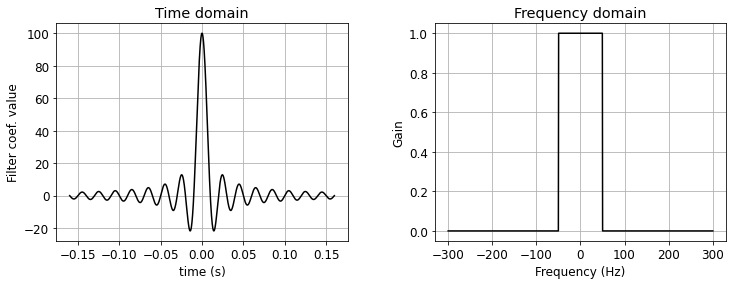

In [2]:
# Note that we cannot plot the true h(t) and H(w) on digital computers
# Figures below are just approximation 
import numpy as np

# F_c = 50Hz
f_c = 50

# freq domain
x_data = np.linspace(-300, 300, 1000)
y_data = np.zeros(x_data.shape)
y_data[np.bitwise_and(x_data>(-f_c), x_data<(f_c))] = 1.0
fig = plt.figure(figsize=(12, 4)); axis=fig.add_subplot(122);
plot_data(x_data, y_data, fig, axis, 'Frequency (Hz)', 'Gain', 'Frequency domain')

# time domain
x_data_t = np.linspace(-0.16, 0.16, 10001)
y_data_t = 2 * f_c * np.sinc(2 * f_c * x_data_t)
axis = fig.add_subplot(121)
plot_data(x_data_t, y_data_t, fig, axis, 'time (s)', 'Filter coef. value', 'Time domain')
fig.subplots_adjust(hspace=0, wspace=0.3)

#### 1.2 Ideal sinc filter in discrete time domain
We cannot directly use the ideal impulse response of the low-pass filter because digital systems do not work in continuous time domain. 

We have to use discrete-time versions. 

Suppose we are sampling the ideal impulse response at $F_s=400 Hz$. The sampled impulse response can be written as 
$h[n] = \frac{sin(2  \pi f_c \frac{n}{F_s})}{\pi n}= \frac{sin(\pi w_c n)}{\pi n}$, where $w_c = \frac{2f_c}{F_s}$. Note that we ignore the $F_s$ in the denominator. 

Also note that $w_c = \frac{2f_c}{F_s} = \frac{f_c}{\frac{F_s}{2}}$ so that $w_c \in (0, 1)$ for $f_c\in(0, \frac{F_s}{2})$. This $w_c$ is known as the Normalized Frequency (see Alternative normalizations in https://en.wikipedia.org/wiki/Normalized_frequency_(unit)). This is convenient when we want to predict $w_c$ from neural networks.

The frequency and time domain of the discrete-time filter $h[n]$ will be:

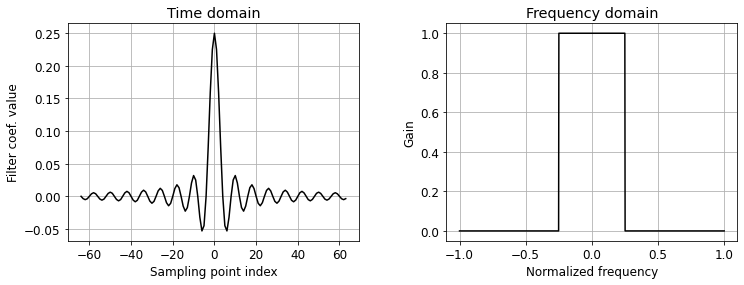

In [3]:
# Discrete time Fourier transform
# Some useful online materials https://courses.engr.illinois.edu/ece401/sp2017/lecture13dtft.pdf
# https://courses.engr.illinois.edu/ece401/sp2017/lecture13dtft.pdf
# Note that w_c in this notebook refers to \frac{2f_c}/{F_s}, not w in above materials

# Frequency domain
f_s = 400
w_c = 2*f_c / f_s

fig = plt.figure(figsize=(12, 4)); axis=fig.add_subplot(122);
x_data = np.linspace(-1, 1, 1000)
y_data = np.zeros(x_data.shape)
y_data[np.bitwise_and(x_data>(-w_c), x_data<(w_c))] = 1.0
plot_data(x_data, y_data, fig, axis, 'Normalized frequency', 'Gain', 'Frequency domain')


# just plot part of the infinitely long filter
plot_range_inf = [-64, 64]
x_data_t = np.arange(plot_range_inf[0], plot_range_inf[1])
y_data_t = w_c * np.sinc(w_c * x_data_t)
axis = fig.add_subplot(121)
plot_data(x_data_t, y_data_t, fig, axis, 'Sampling point index', 'Filter coef. value', 'Time domain')
fig.subplots_adjust(hspace=0, wspace=0.3)

The figure of `Frequency domain` plots frequency response for $w_c$ in the range $(-1, 1)$. Of course, $(-1, 0)$ is just mirror of (0, 1). In many cases, we only plot the positive range $w_c\in(0, 1)$.

#### 1.3 Windowed sinc filter in discrete time domain

However, it is still impossible for implementation because the discrete time ideal filter is infinitely long, i.e., $n\in\{-\infty, \cdots, \infty\}$. (Although I plot the figures in 1.1 and 1.2, they are plotted only within a finite range for `plot_range_inf = [-64, 64]`.)  

We need to truncate the impulse response, for example, by setting $h[n]=0$ for $n<-M$ and $n>M$. Then, we only store and use $h[n]$ for $n\in[-M, M]$. However, such a simple truncating method leads to ripples in the passband (i.e., Gibbs effect).

One better choice is to truncate the filter impulse response by multiplying it with a finite-length window function, such as [Hamming window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows): $\text{Hamming}(n) = 0.54 + 0.46\cos(2\pi n / (2M+1)), n \in[-M, M]$.

The length of the truncated filter, or equivalently the length of the finite-length window $2M+1$, is referred to as the order of the windowed-sinc filter.


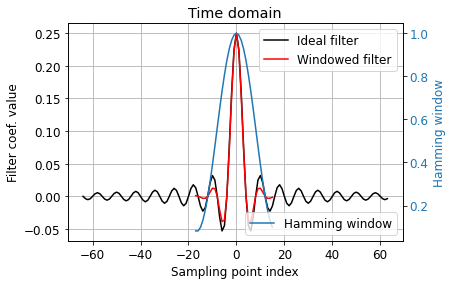

In [4]:
fig = plt.figure(figsize=(12//2, 4)); axis=fig.add_subplot(111);

# just plot part of the infinitely long filter
x_data_t_inf = np.arange(plot_range_inf[0], plot_range_inf[1])
y_data_t_inf = w_c * np.sinc(w_c * x_data_t_inf)

# plot the truncated case
# let's use a filter of order 33
filter_order = 33

x_data_t = np.arange(-filter_order//2, filter_order//2)
# hamming window
y_hamming = 0.54 + 0.46 * np.cos(2 * np.pi * x_data_t / filter_order)
# truncated part not windowed
y_data_t = w_c * np.sinc(w_c * x_data_t)
# truncated and windowed
y_data_t_windowed = y_data_t * y_hamming

# 
plot_data(x_data_t_inf, y_data_t_inf, fig, axis, 'Sampling point index', 'Filter coef. value', 'Time domain')
axis.plot(x_data_t, y_data_t_windowed, 'r')
axis.legend(['Ideal filter', 'Windowed filter'])

ax2 = axis.twinx()
color = 'tab:blue'
ax2.set_ylabel('Hamming window', color=color)
ax2.plot(x_data_t, y_hamming, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Hamming window'], loc=4)

The Fourier transform of truncated filter will be equal to the convolution of the frequency response of Hamming window and the idea low-pass filter. 

Sometimes the windowed sinc filter may alter the energy of frequency components in the pass band. To make sure that the low-pass filter gain is 1.0 at 0Hz, we can do a simple normalization:

${h}[n] \leftarrow \frac{{h}[n] \text{Hamming}(n)}{\sum_n {h}[n] \text{Hamming}(n)}$


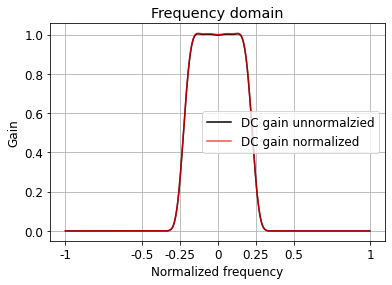

In [5]:
import scipy
import scipy.signal

# Frequency response of the windowed sinc filter
# number of FFT points
fft_N=512

# calcualte frequency response, unnormalized
_, freq_res = scipy.signal.freqz(y_data_t_windowed, [1], worN=fft_N, whole=True)
# shift from [0, 2pi] to [-pi, pi] for plotting
freq_res = np.roll(freq_res, fft_N//2)

# normalized
y_data_t_windowed_normed = y_data_t_windowed / y_data_t_windowed.sum()
_, freq_res_normed = scipy.signal.freqz(y_data_t_windowed_normed, [1], worN=fft_N, whole=True)
freq_res_normed = np.roll(freq_res_normed, fft_N//2)


# plotting
fig = plt.figure(figsize=(12//2, 4)); axis=fig.add_subplot(111);
fig, axis = plot_data(np.arange(freq_res.shape[0]), np.power(np.abs(freq_res), 2), fig, axis,
                      'Normalized frequency', 'Gain', 'Frequency domain')
axis.plot(np.arange(freq_res_normed.shape[0]), np.power(np.abs(freq_res_normed), 2), 'r', alpha=0.7);

# plotting with labels
axis.set_xticks([0, fft_N//4, fft_N//8*3, fft_N//2, fft_N//8*5, fft_N//4*3, fft_N])
axis.set_xticklabels(["-1", '-0.5', '-0.25', '0', '0.25', '0.5', "1"])
axis.legend(['DC gain unnormalzied', 'DC gain normalized'])

# for this example, normalization is not necessary since y_data_t_windowed.sum() is alreay close to 1.0

#### 1.4 Wrap up

Examples above are low-pass filters. 
Based on similar principle, we can also generate high-pass windowed sinc filters. 
Just note that the normalization on high-pass filters is 
$\tilde{h}[n] = \frac{{h}[n] * \text{Hamming}(n)}{\sum_n (-1)^n {h}[n] \text{Hamming}(n)}$.


For convenience, we summarize the steps for creating high- and low-pass windowed-sinc filters as Python functions below:

In [6]:
def return_winwdoed_sinc_low_pass(w_c, filter_order, norm=False):
    """ return_winwdoed_sinc_low_pass(w_c, filter_order, norm=False)
    Input:
        w_c: a real number, normalized cut-off frequency between (0, 1)
        filter_order: an odd integer number. The filter range will be [-filter_order//2, filter_order//2]
        norm: whether do gain normalization (default False)
    Output:
        y_data_t_windowed: low-pass filter coefficients
        y_hamming: hamming window coefficients
        x_data_t: time index for plotting figures
    """
    # x index
    x_data_t = np.arange(-filter_order//2, filter_order//2)
    # hamming window
    y_hamming = 0.54 + 0.46 * np.cos(2 * np.pi * x_data_t / x_data_t.shape[0])
    # truncated part not windowed
    y_data_t = w_c * np.sinc(w_c * x_data_t)
    # truncated and windowed
    y_data_t_windowed = y_data_t * y_hamming
    # normalize pass-band gain if necessary
    if norm:
        y_data_t_windowed = y_data_t_windowed/y_data_t_windowed.sum()
        
    # return filter coefficients, hamming window, and time step index
    return y_data_t_windowed, y_hamming, x_data_t

def return_winwdoed_sinc_high_pass(w_c, filter_order, norm=False):
    """ return_winwdoed_sinc_high_pass(w_c, filter_order, norm=False)
    Input:
        w_c: a real number, normalized cut-off frequency between (0, 1)
        filter_order: an odd integer number. The filter range will be [-filter_order//2, filter_order//2]
        norm: whether do gain normalization (default False)
    Output:
        y_data_t_windowed: high-pass filter coefficients
        y_hamming: hamming window coefficients
        x_data_t: time index for plotting figures
    """
    # x index
    x_data_t = np.arange(-filter_order//2, filter_order//2)
    # hamming window
    y_hamming = 0.54 + 0.46 * np.cos(2 * np.pi * x_data_t / x_data_t.shape[0])
    # truncated part not windowed
    y_data_t = np.sinc(1.0 * x_data_t) - w_c * np.sinc(w_c * x_data_t)
    # truncated and windowed
    y_data_t_windowed = y_data_t * y_hamming
    
    # normalize pass-band gain if necessary
    if norm:
        minus_one = np.power(-1, np.abs(x_data_t))
        y_data_t_windowed = y_data_t_windowed/(y_data_t_windowed*minus_one).sum()
    # return filter coefficients, hamming window, and time step index
    return y_data_t_windowed, y_hamming, x_data_t


Below is a wrapper just for plotting the filter in time and frequency domains.
These lines uses the function above to create the windowed sinc filters.
```
y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_low_pass(w_c, filter_order, True)

y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_high_pass(w_c, filter_order, True)
```

In [7]:

def plot_windowed_case(w_c, filter_order, plot_range_inf=[-64, 64], 
                       low_pass=True, only_window_filter=False, half_freq=False,
                       grid_on=True):
    """ A wrapper to plot the filters in frequency and time domain
    w_c: cut-off frequency, a real-number between (0, 1)
    filter_order: filter order, an integer number
    plot_range_inf: [-P, P], this is used to set the x-range for plotting ideal filter
    """
    # wrapper to plot figures
    def plot_data(x_data, y_data, fig, axis, xlabel, ylabel, title, grid_on):    
        axis.plot(x_data, y_data, 'k')
        axis.grid(grid_on)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.set_title(title)
    
    fig = plt.figure(figsize=(12, 4)); 
    
    axis=fig.add_subplot(121);
    # just plot part of the infinitely long filter
    x_data_t_inf = np.arange(plot_range_inf[0], plot_range_inf[1])
    if low_pass:
        y_data_t_inf = w_c * np.sinc(w_c * x_data_t_inf)
    else:
        y_data_t_inf = np.sinc(x_data_t_inf) - w_c * np.sinc(w_c * x_data_t_inf)
        
    if not only_window_filter:
        plot_data(x_data_t_inf, y_data_t_inf, fig, axis, 'Sampling point index', 'Filter coef. value', 'Time domain', grid_on)
        axis.set_xlim(plot_range_inf)
    
    # get and plot the truncated case
    if low_pass:
        y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_low_pass(w_c, filter_order, True)
    else:
        y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_high_pass(w_c, filter_order, True)
    if not only_window_filter:
        axis.plot(x_data_t, y_data_t_windowed, 'r')
        axis.legend(['Ideal filter', 'Windowed filter'])
    else:
        plot_data(x_data_t, y_data_t_windowed, fig, axis, 'Sampling point index', 'Filter coef. value', 'Time domain', grid_on)

    # plot the hamming window
    if not only_window_filter:
        ax2 = axis.twinx()
        ax2.set_ylabel('Hamming window', color='tab:blue')
        ax2.plot(x_data_t, y_hamming, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        ax2.legend(['Hamming window'], loc=4)
    
    # plot frequency response
    axis=fig.add_subplot(122);
    
    fft_N=512
    _, freq_res = scipy.signal.freqz(y_data_t_windowed, [1], worN=fft_N, whole=True)
    # shift from [0, 2pi] to [-pi, pi] for plotting
    if not half_freq:
        freq_res = np.roll(freq_res, fft_N//2)
        plot_data(np.arange(freq_res.shape[0]), np.abs(freq_res), fig, axis, 'Normalized frequency', 'Gain', 'Frequency domain', grid_on)
        axis.set_xticks([int(fft_N * x) for x in [0, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8, 1]])
        axis.set_xticklabels(["-1", '-0.75', '-0.5', '-0.25', '0', '0.25', '0.5', '0.75', "1"])
    else:
        plot_data(np.arange(fft_N//2+1), np.abs(freq_res[0:fft_N//2+1]), fig, axis, 'Normalized frequency', 'Gain', 'Frequency domain', grid_on)
        axis.set_xticks([0, fft_N//8, fft_N//4, fft_N//8*3, fft_N//2])
        axis.set_xticklabels(['0', '0.25', '0.5', '0.75', "1"])
    if low_pass:
        fig.text(0.5, 0.98, "w_c: %0.2f, order: %d, loss-pass" % (w_c, filter_order), horizontalalignment='center')
    else:
        fig.text(0.5, 0.98, "w_c: %0.2f, order: %d, high-pass" % (w_c, filter_order), horizontalalignment='center')
    fig.subplots_adjust(hspace=0, wspace=0.3)
    return


We can compare the impact of the filter order. Here we only plot the positive frequency range (0, 1).

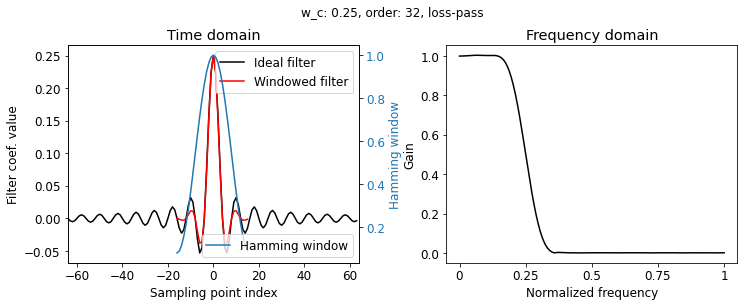

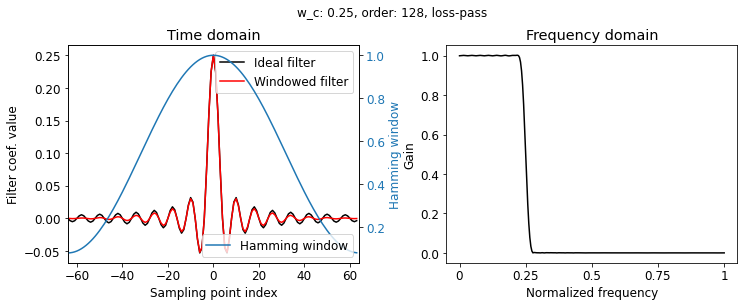

In [8]:
# plot a few cases with different filter order
plot_windowed_case(w_c, filter_order=32,  low_pass=True, half_freq=True, grid_on=False)
plot_windowed_case(w_c, filter_order=128, low_pass=True, half_freq=True, grid_on=False)
#plot_windowed_case(w_c, filter_order=32,  low_pass=False)
#plot_windowed_case(w_c, filter_order=128, low_pass=False)

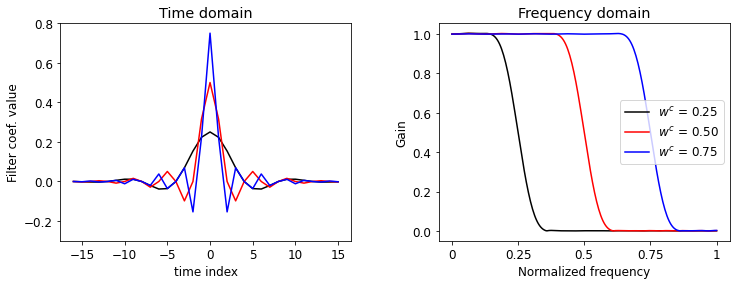

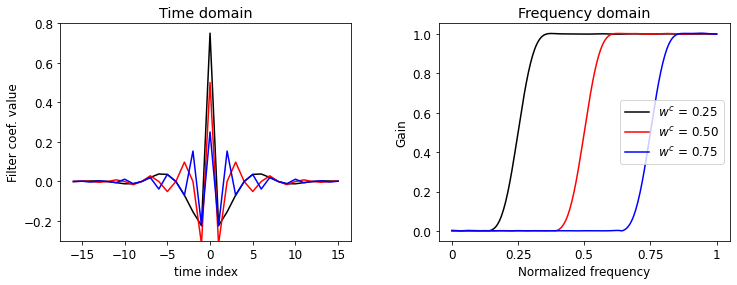

In [9]:
# This is another wrapper for figure plotting.

def plot_windowed_case2(w_c_list, legends, filter_order, plot_range_inf=[-64, 64], low_pass=True, grid_on=True):
    color_bags = ['k', 'r', 'b', 'g']
    if len(w_c_list) > len(color_bags):
        print("Not enough colors")
        return
    
    # wrapper to plot figures
    def plot_data(x_data, y_data, fig, axis, xlabel, ylabel, title, grid_on, color):    
        axis.plot(x_data, y_data, color)
        axis.grid(grid_on)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.set_title(title)
    
    fig = plt.figure(figsize=(12, 4)); 
    
    # get and plot the truncated case
    axis=fig.add_subplot(121);
    for w_c, color in zip(w_c_list, color_bags):
        if low_pass:
            y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_low_pass(w_c, filter_order, True)
        else:
            y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_high_pass(w_c, filter_order, True)
        plot_data(x_data_t, y_data_t_windowed, fig, axis, 'time index', 'Filter coef. value', 'Time domain', grid_on, color)
        axis.set_ylim(-0.3, 0.8)
        
    axis=fig.add_subplot(122);
    for w_c, color in zip(w_c_list, color_bags):
        if low_pass:
            y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_low_pass(w_c, filter_order, True)
        else:
            y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_high_pass(w_c, filter_order, True)
        
        # plot frequency response
        fft_N=512
        _, freq_res = scipy.signal.freqz(y_data_t_windowed, [1], worN=fft_N, whole=True)
        # shift from [0, 2pi] to [-pi, pi] for plotting
        plot_data(np.arange(fft_N//2+1), np.abs(freq_res[0:fft_N//2+1]), fig, axis, 'Normalized frequency', 'Gain', 'Frequency domain', grid_on, color)
        axis.set_xticks([0, fft_N//8, fft_N//4, fft_N//8*3, fft_N//2])
        axis.set_xticklabels(['0', '0.25', '0.5', '0.75', "1"])
    axis.legend(legends);
    fig.subplots_adjust(hspace=0, wspace=0.3)
    return


plot_windowed_case2([0.25, 0.5, 0.75], ["$w^c$ = 0.25", "$w^c$ = 0.50", "$w^c$ = 0.75"],filter_order=32, low_pass=True, grid_on=False)
plot_windowed_case2([0.25, 0.5, 0.75], ["$w^c$ = 0.25", "$w^c$ = 0.50", "$w^c$ = 0.75"],filter_order=32, low_pass=False, grid_on=False)

#for w_c in [0.25, 0.5, 0.75]:
#    plot_windowed_case2([w_c], ["$w^c$ = %0.2f" % (w_c)], filter_order=32, low_pass=True, grid_on=False)
#    plot_windowed_case2([w_c], ["$w^c$ = %0.2f" % (w_c)], filter_order=32, low_pass=False, grid_on=False)

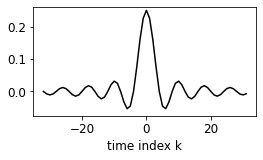

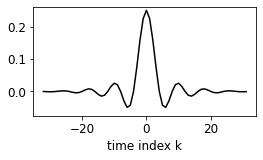

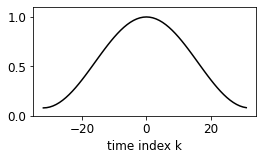

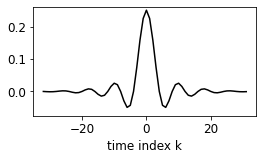

In [10]:
figure_size=(4,2)
for w_c in [0.25]:
    filter_coef, hamming, x_index = return_winwdoed_sinc_low_pass(w_c, 64, False)
    fig = plt.figure(figsize=figure_size);
    axis=fig.add_subplot(111);
    #axis.stem(x_index, filter_coef / hamming, 'k-', 'ko', 'k', use_line_collection=True)
    axis.plot(x_index, filter_coef / hamming, 'k')
    axis.set_xlabel("time index k")
    axis.set_ylim(-0.075, 0.26)
    
    fig = plt.figure(figsize=figure_size);
    axis=fig.add_subplot(111);
    #axis.stem(x_index, filter_coef, 'k-', 'ko', 'k', use_line_collection=True)
    axis.plot(x_index, filter_coef, 'k')
    axis.set_xlabel("time index k")
    axis.set_ylim(-0.075, 0.26)

    fig = plt.figure(figsize=figure_size);
    axis=fig.add_subplot(111);
    #axis.stem(x_index, hamming, 'k-', 'ko', 'k', use_line_collection=True)
    axis.plot(x_index, hamming, 'k')
    axis.set_xlabel("time index k")
    axis.set_ylim(-0.0, 1.1)

    fig = plt.figure(figsize=figure_size);
    axis=fig.add_subplot(111);
    #axis.stem(x_index, filter_coef / filter_coef.sum(), 'k-', 'ko', 'k', use_line_collection=True)
    axis.plot(x_index, filter_coef / filter_coef.sum(), 'k')
    axis.set_xlabel("time index k")
    axis.set_ylim(-0.075, 0.26)
    

### 2. Module Definition

Behaviors of this wrapper is:
1. Input $w_{1:N}^{(c)}$ as tensor of shape (batchsize, length, 1)
2. Output low-pass filter coefficients is a tensor (batchsize, length, filter_order)
3. Output high-pass filter coefficients is a tensor (batchsize, length, filter_order)
4. $w_n^{(c)}\in(0, 1)$

In such as case, the filte cofficients (i, n, :) correspond to the filter for the $n$-th time step and the $i$-th signal in the batch.

The wrapper does operations shown in the figure below:

![Images_2](./figures/fig_c8_1.png)

Note that this process is differentiable. Once we know the gradients w.r.t filter coefficients, we can back-propagate the gradients and get the gradients w.r.t $w_c$ (shown in blue arrows).

The above figure shows the procedure to produce one filter pair for one $w_c$. 
In practice, the input may be a sequence $\{w_{1}^{(c)}, w_{2}^{(c)}, \cdots, w_{N}^{(c)}\}$. We will generate a sequence of high and low-pass filter coefficients $\{\{\boldsymbol{h}_{1}^{(hp)}, \boldsymbol{h}_{1}^{(lp)}\}, \{\boldsymbol{h}_{2}^{(hp)}, \boldsymbol{h}_{2}^{(lp)}\}, \cdots, \{\boldsymbol{h}_{N}^{(hp)}, \boldsymbol{h}_{N}^{(lp)}\}\}$, where $\boldsymbol{h}_{n}^{(lp)}=[{h}_{0, n}^{(lp)}, {h}_{1, n}^{(lp)}, \cdots, {h}_{K-1, n}^{(lp)}]$ and $\boldsymbol{h}_{n}^{(hp)}=[{h}_{0, n}^{(hp)}, {h}_{1, n}^{(hp)}, \cdots, {h}_{K-1, n}^{(hp)}]$

In [11]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys


In [12]:
# Sinc filter generator
class SincFilter(torch_nn.Module):
    """ SincFilter
        Given the cut-off-frequency, produce the low-pass and high-pass
        windowed-sinc-filters.
        If input cut-off-frequency is (batchsize, signal_length, 1),
        output filter coef is (batchsize, signal_length, filter_order).
        
        For each time step in [1, signal_length), we calculate one
        filter for low-pass sinc filter and another for high-pass filter.
        
        Example:
        import scipy
        import scipy.signal
        import numpy as np
        
        filter_order = 31
        cut_f = 0.2
        sinc_layer = SincFilter(filter_order)
        lp_coef, hp_coef = sinc_layer(torch.ones(1, 10, 1) * cut_f)
        
        w, h1 = scipy.signal.freqz(lp_coef[0, 0, :].numpy(), [1])
        w, h2 = scipy.signal.freqz(hp_coef[0, 0, :].numpy(), [1])
        plt.plot(w, 20*np.log10(np.abs(h1)))
        plt.plot(w, 20*np.log10(np.abs(h2)))
        plt.plot([cut_f * np.pi, cut_f * np.pi], [-100, 0])
    """
    def __init__(self, filter_order):
        super(SincFilter, self).__init__()
        # Make the filter oder an odd number
        #  [-(M-1)/2, ... 0, (M-1)/2]
        # 
        self.half_k = (filter_order - 1) // 2
        self.order = self.half_k * 2 +1
        
    def hamming_w(self, n_index):
        """ prepare hamming window for each time step
        n_index (batchsize=1, signal_length, filter_order)
            For each time step, n_index will be [-(M-1)/2, ... 0, (M-1)/2]
            n_index[0, 0, :] = [-(M-1)/2, ... 0, (M-1)/2]
            n_index[0, 1, :] = [-(M-1)/2, ... 0, (M-1)/2]
            ...
        output  (batchsize=1, signal_length, filter_order)
            output[0, 0, :] = hamming_window
            output[0, 1, :] = hamming_window
            ...
        """
        # Hamming window
        return 0.54 + 0.46 * torch.cos(2 * np.pi * n_index / self.order)
    
    def sinc(self, x):
        """ Normalized sinc-filter sin( pi * x) / pi * x
        https://en.wikipedia.org/wiki/Sinc_function
        
        Assume x (batchsize, signal_length, filter_order) and 
        x[0, 0, :] = [-half_order, - half_order+1, ... 0, ..., half_order]
        x[:, :, self.half_order] -> time index = 0, sinc(0)=1
        """
        y = torch.zeros_like(x)
        y[:,:,0:self.half_k]=torch.sin(np.pi * x[:, :, 0:self.half_k]) \
                                / (np.pi * x[:, :, 0:self.half_k])
        y[:,:,self.half_k+1:]=torch.sin(np.pi * x[:, :, self.half_k+1:]) \
                                / (np.pi * x[:, :, self.half_k+1:])
        y[:,:,self.half_k] = 1
        return y
        
    def forward(self, cut_f):
        """ lp_coef, hp_coef = forward(self, cut_f)
        cut-off frequency cut_f (batchsize=1, length, dim = 1)
    
        lp_coef: low-pass filter coefs  (batchsize, length, filter_order)
        hp_coef: high-pass filter coefs (batchsize, length, filter_order)
        """
        # create the filter order index
        with torch.no_grad():   
            # [- (M-1) / 2, ..., 0, ..., (M-1)/2]
            lp_coef = torch.arange(-self.half_k, self.half_k + 1, 
                                   device=cut_f.device)
            # [[[- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   [- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   ...
            #  ],
            #  [[- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   [- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   ...
            #  ]]
            lp_coef = lp_coef.repeat(cut_f.shape[0], cut_f.shape[1], 1)
            
            hp_coef = torch.arange(-self.half_k, self.half_k + 1, 
                                   device=cut_f.device)
            hp_coef = hp_coef.repeat(cut_f.shape[0], cut_f.shape[1], 1)
            
            # temporary buffer of [-1^n] for gain norm in hp_coef
            tmp_one = torch.pow(-1, hp_coef)
            
        # unnormalized filter coefs with hamming window
        lp_coef = cut_f * self.sinc(cut_f * lp_coef) \
                  * self.hamming_w(lp_coef)
        hp_coef = (self.sinc(hp_coef)-cut_f * self.sinc(cut_f * hp_coef))\
                  * self.hamming_w(hp_coef)
        
        # normalize the coef to make gain at 0/pi is 0 dB
        # sum_n lp_coef[n]
        lp_coef_norm = torch.sum(lp_coef, axis=2).unsqueeze(-1)
        # sum_n hp_coef[n] * -1^n
        hp_coef_norm = torch.sum(hp_coef * tmp_one, axis=2).unsqueeze(-1)
        
        lp_coef = lp_coef / lp_coef_norm
        hp_coef = hp_coef / hp_coef_norm
        
        # return normed coef
        return lp_coef, hp_coef

### 3. Example

Let's consider a simple example where the time length is only 4.

Let's use batch size of 2 and generate two sets of filters.

(<Figure size 1130.4x158.4 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7f905b4cc9d0>])

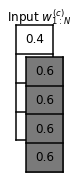

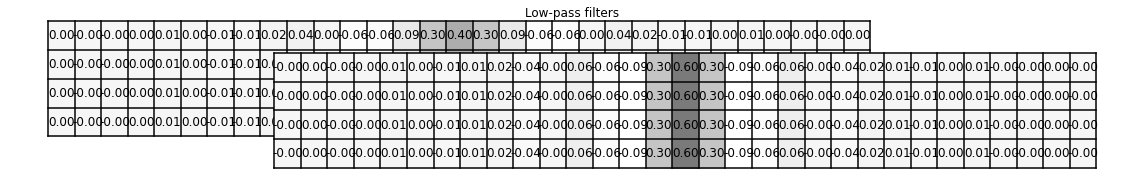

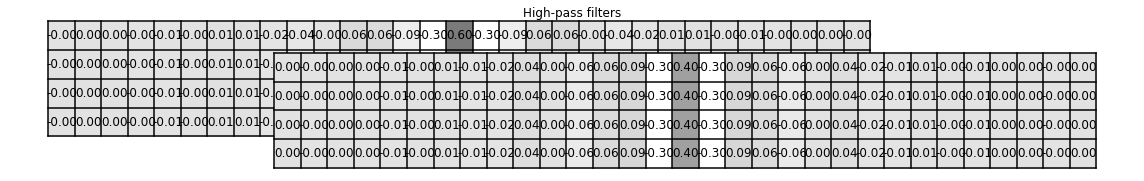

In [13]:
# configuration
# length of the signal
signal_length = 4
# cut-off-frequency for 1st signal in the batch
sinc_cut_off_1 = 0.4
# cut-off-frequency for 2nd signal in the batch
sinc_cut_off_2 = 0.6

sinc_cut_off_freq = torch.ones(2, signal_length, 1) * sinc_cut_off_1
sinc_cut_off_freq[1, :, :] = torch.ones(signal_length, 1) * sinc_cut_off_2


# initialzie the layer
# order of the sinc filters
sinc_filter_order = 31
sinc_layer = SincFilter(sinc_filter_order)

# get the pair of high- and low-pass filter coefficients 
lp_coef, hp_coef = sinc_layer(sinc_cut_off_freq)
# the format of the filter coefficients will be 
# (batchsize, signal_length, filter_order)

import plot_lib
plot_lib.plot_tensor(sinc_cut_off_freq, color_on_value=True, shift=0.2, title='Input $w_{1:N}^{(c)}$')
plot_lib.plot_tensor(lp_coef, color_on_value=True, shift=0.2, deci_width=2, title='Low-pass filters')
plot_lib.plot_tensor(hp_coef, color_on_value=True, shift=0.2, deci_width=2, title='High-pass filters')

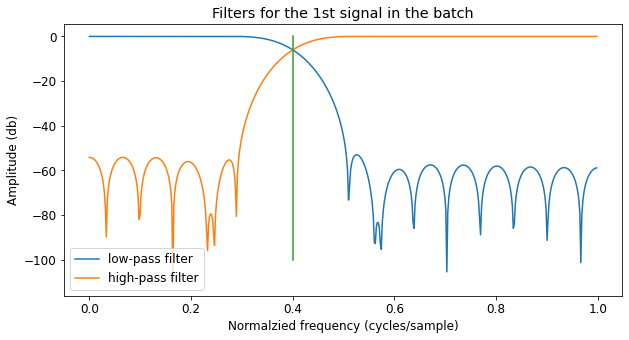

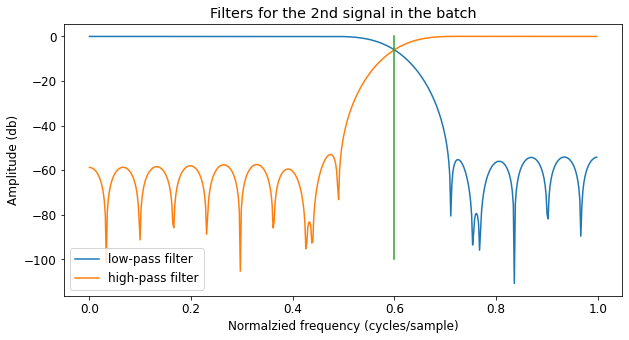

In [14]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


import scipy
import scipy.signal

# which time step to check?
# Just plot the first time step
time_step = 0

# frequency response of the filters for the first signal, at time step 0
w, h1 = scipy.signal.freqz(lp_coef[0, time_step, :].numpy(), [1])
w, h2 = scipy.signal.freqz(hp_coef[0, time_step, :].numpy(), [1])
plt.figure()
plt.plot(w/np.pi, 20*np.log10(np.abs(h1)))
plt.plot(w/np.pi, 20*np.log10(np.abs(h2)))
plt.plot([sinc_cut_off_1, sinc_cut_off_1], [-100, 0])
plt.ylabel('Amplitude (db)')
plt.xlabel('Normalzied frequency (cycles/sample)')
plt.title("Filters for the 1st signal in the batch")
plt.legend(["low-pass filter", "high-pass filter"])
# frequency response of the filters in the first batch

# frequency response of the filters for the second signal, at time step 0
plt.figure()
w, h1 = scipy.signal.freqz(lp_coef[1, time_step, :].numpy(), [1])
w, h2 = scipy.signal.freqz(hp_coef[1, time_step, :].numpy(), [1])
plt.plot(w / np.pi, 20*np.log10(np.abs(h1)))
plt.plot(w / np.pi, 20*np.log10(np.abs(h2)))
plt.plot([sinc_cut_off_2 , sinc_cut_off_2], [-100, 0])
plt.ylabel('Amplitude (db)')
plt.xlabel('Normalzied frequency (cycles/sample)')
plt.title("Filters for the 2nd signal in the batch")
plt.legend(["low-pass filter", "high-pass filter"])


### 4. Use sinc-based filters

Sinc filters can be used in TimeVariantFiltering layer.

Here we use the sinc-filter generated above to process random signals.

In [15]:
# generate the low-pass and high-pass filters
# 
signal_length = 4000

# let's create a time variant sinc filter
sinc_cut_off_1 = 0.4
sinc_cut_off_2 = 0.6
sinc_cut_off_freq = torch.ones(1, signal_length, 1) 

# first 1/4 part uses w_c = 0.4
# middle 1/2 part uses w_c = 0.6
# last 1/4 part uses w_c = 0.4
sinc_cut_off_freq[0, 0:signal_length//4, :] = sinc_cut_off_1
sinc_cut_off_freq[0, signal_length//4:signal_length*3//4, :] = sinc_cut_off_2
sinc_cut_off_freq[0, signal_length*3//4:, :] = sinc_cut_off_1

# initialzie the layer
sinc_filter_order = 31
sinc_layer = SincFilter(sinc_filter_order)

# get the pair of high- and low-pass filter coefficients 
lp_coef, hp_coef = sinc_layer(sinc_cut_off_freq)

(33.0, 0.0)

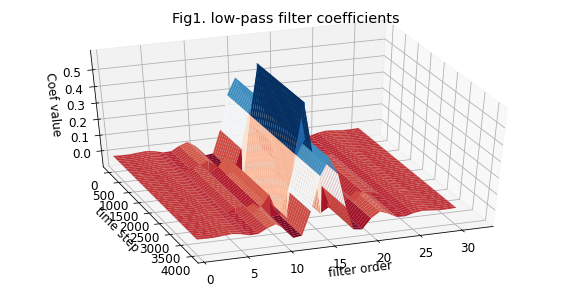

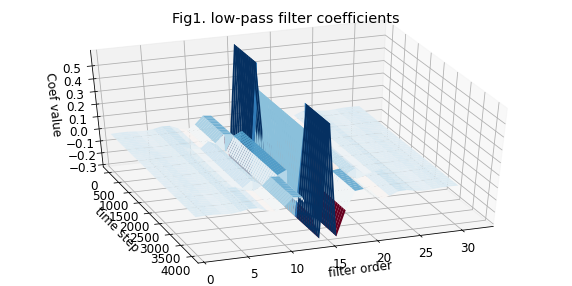

In [16]:
# plot the filters in time domain
plot_batch = 0
fig = plt.figure(); ax = fig.gca(projection='3d')
plot_lib.plot_surface(lp_coef[plot_batch].numpy().T, fig, ax, 
                      ylabel='time step', xlabel='filter order', zlabel='Coef value', 
                      angleX=40, angleY=70)
ax.set_title("Fig1. low-pass filter coefficients")
ax.set_xlim(filter_order, 0)

fig = plt.figure(); ax = fig.gca(projection='3d')
plot_lib.plot_surface(hp_coef[plot_batch].numpy().T, fig, ax, 
                      ylabel='time step', xlabel='filter order', zlabel='Coef value', 
                      angleX=40, angleY=70)
ax.set_title("Fig1. low-pass filter coefficients")
ax.set_xlim(filter_order, 0)

(2049.0, 0.0)

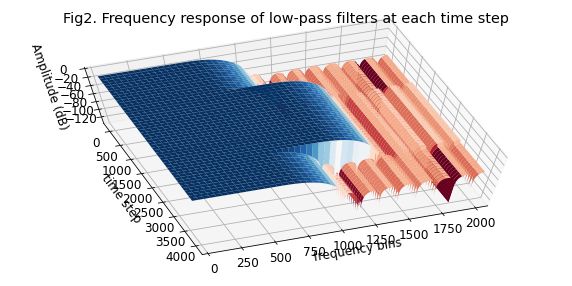

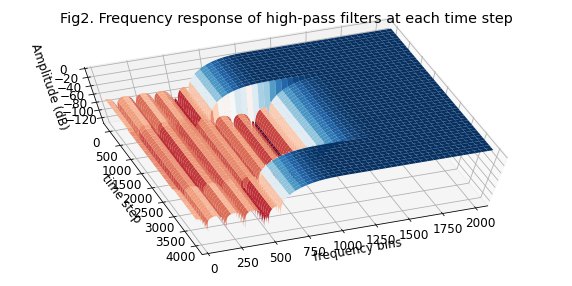

In [17]:
# plot the frequency response of filters for each time step (this may take some time)
# for simplicity, just calculate the frequency response for a few time steps and
# duplicate it to other time steps
def get_fft_amp_(data, nfft):
    w, fres = scipy.signal.freqz(data, [1], worN=nfft, whole=True)
    return 20*np.log10(np.abs(fres[0:nfft//2+1]) + np.finfo(np.float32).eps)

nfft=int(np.power(2, np.ceil(np.log2(signal_length))))

lp_filter_res = np.zeros([lp_coef.shape[1], nfft//2+1])
lp_filter_res[0:signal_length//4, :] = get_fft_amp_(lp_coef[0, 0, :], nfft)
lp_filter_res[signal_length//4:signal_length*3//4, :] = get_fft_amp_(lp_coef[0, signal_length//4, :], nfft)
lp_filter_res[signal_length*3//4:, :] = get_fft_amp_(lp_coef[0, signal_length*3//4, :], nfft)

hp_filter_res = np.zeros([hp_coef.shape[1], nfft//2+1])
hp_filter_res[0:signal_length//4, :] = get_fft_amp_(hp_coef[0, 0, :], nfft)
hp_filter_res[signal_length//4:signal_length*3//4, :] = get_fft_amp_(hp_coef[0, signal_length//4, :], nfft)
hp_filter_res[signal_length*3//4:, :] = get_fft_amp_(hp_coef[0, signal_length*3//4, :], nfft)


fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(lp_filter_res.T, fig, ax, 
                      ylabel='time step', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig2. Frequency response of low-pass filters at each time step")
ax.set_xlim(nfft//2+1, 0)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(hp_filter_res.T, fig, ax, 
                      ylabel='time step', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig2. Frequency response of high-pass filters at each time step")
ax.set_xlim(nfft//2+1, 0)

Let's now generate a random signal and do time variant filtering.

In [18]:
# repeat the Module definition of here
class TimeVariantFiltering(torch_nn.Module):
    def __init__(self):
        super(TimeVariantFiltering, self).__init__()
    
    def forward(self, signal, f_coef):
        signal_l = signal.shape[1]
        order_k = f_coef.shape[-1]
        # pad to (batchsize=1, signal_length + filter_order-1, dim)
        padded_signal = torch_nn_func.pad(signal, (0, 0, 0, order_k - 1))
        
        output = torch.zeros_like(signal)
        # roll and weighted sum, only take [0:signal_length]
        for k in range(order_k):
            output += torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :] \
                      * f_coef[:, :, k:k+1] 
        return output

In [19]:
# Generate the signals and make sure that the amplitude of signal is around 0 dB
signal_input_raw = torch.randn(1, signal_length, 1)
signal_input = signal_input_raw
signal_input[0, :, :] = signal_input_raw[0, :, :] / np.abs(scipy.fft.fft(signal_input_raw[0, :, 0].detach().numpy(), n=nfft)).mean()

# Do filtering
tv_layer = TimeVariantFiltering()

signal_input.requires_grad=False
data_lp = tv_layer(signal_input, lp_coef)
data_hp = tv_layer(signal_input, hp_coef)

(2049.0, 0.0)

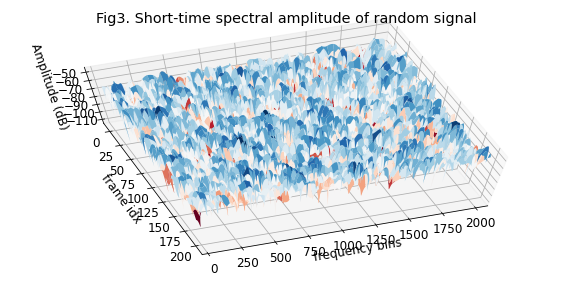

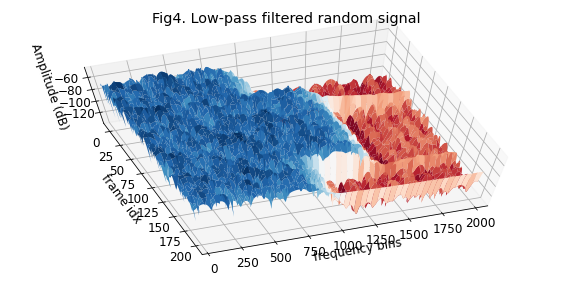

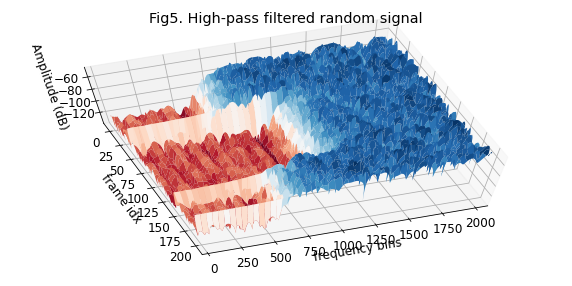

In [20]:
# Plot 
# let's try to plot the spectrogram
import tool_lib
signal_in_examine = signal_input[0, :, 0]
signal_out_lp = data_lp[0, :, 0]
signal_out_hp = data_hp[0, :, 0]

nfft=int(np.power(2, np.ceil(np.log2(signal_length))))
spec_in_examine = tool_lib.spec_amplitude(signal_in_examine, frame_length=200, frame_shift=20, fft_bins=nfft)
spec_out_lp = tool_lib.spec_amplitude(signal_out_lp, frame_length=200, frame_shift=20, fft_bins=nfft)
spec_out_hp = tool_lib.spec_amplitude(signal_out_hp, frame_length=200, frame_shift=20, fft_bins=nfft)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_in_examine, fig, ax, 
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig3. Short-time spectral amplitude of random signal")
ax.set_xlim(nfft//2+1, 0)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_out_lp, fig, ax, 
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig4. Low-pass filtered random signal")
ax.set_xlim(nfft//2+1, 0)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_out_hp, fig, ax, 
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig5. High-pass filtered random signal")
ax.set_xlim(nfft//2+1, 0)

### 5. Summary

In this notebook, we define a wrapper to produce windowed sinc filter. 
Behaviors of this wrapper is:
1. Input $w_{1:N}^{(c)}$ as tensor of shape (batchsize, length, 1)
2. Output low-pass filter coefficients is a tensor (batchsize, length, filter_order)
3. Output high-pass filter coefficients is a tensor (batchsize, length, filter_order)
4. $w_n^{(c)}\in(0, 1)$

The low and high pass filters can be used as input to the TimeVariantFilter defined in c7_time_variant_filter.ipynb.

This wrapper is also differentiable. 
We use sinc filters in harmonic-plus-noise NSF with trainable maximum voicing frequency (i.e., cut-off frequency).
We use a small network to predict the cut-off frequency (https://www.isca-speech.org/archive/SSW_2019/abstracts/SSW10_O_1-1.html).
